In [1]:
import gc
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
from time import time
import random

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

from model import resnet

Using TensorFlow backend.


In [2]:
src_path = os.getcwd()
dta_path = os.path.join(src_path, 'data')
os.listdir(dta_path)

['cropped',
 'ids.csv',
 'imgs.npy',
 'labels.csv',
 'msks.npy',
 'radiomics_features.csv']

In [3]:
nodule_id = os.listdir(r'C:\Users\wrrog\Istituto dei Tumori\RadioimcsCNN\data\cropped')

In [4]:
labels = pd.read_csv(os.path.join(dta_path, 'labels.csv'))
print("Total labels:", len(labels))
labels.head()
#labels = labels['survival']
#print(labels[:5])

Total labels: 422


,ids,survival
0,LUNG1-001,2165
1,LUNG1-002,155
2,LUNG1-003,256
3,LUNG1-004,141
4,LUNG1-005,353


In [5]:
new_labels = []
for n, id in enumerate(nodule_id):
    survival = int(labels.loc[labels.ids == id[:9], 'survival'].values[0])
    row = [id, survival]
    new_labels.append(row)

In [6]:
columns = ['id', 'survival']
new_labels = pd.DataFrame(new_labels, columns = columns)
print("Labels length:", len(new_labels))
new_labels.head()

Labels length: 424


,id,survival
0,LUNG1-001,2165
1,LUNG1-002,155
2,LUNG1-003,256
3,LUNG1-004,141
4,LUNG1-005,353


In [7]:
imgs = np.load( os.path.join(dta_path,'imgs.npy') )
imgs = np.rollaxis(imgs, 3, 1)  
print("Images shape:", imgs.shape)

Images shape: (424, 55, 135, 150)


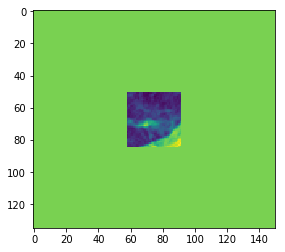

In [8]:
plt.imshow(imgs[200][22, :, :])

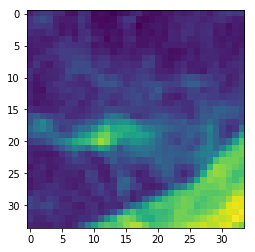

In [9]:
path = r"C:\Users\wrrog\Istituto dei Tumori\RadioimcsCNN\data\cropped" 
path = os.path.join(path, new_labels.loc[200].id)
path = os.path.join(path, 'image.npy')
img = np.load(path)
plt.imshow(img[:, :, 0])

In [10]:
imgs.shape
imgs = imgs.reshape((424, 1, 55, 135, 150))
print("Shape:", imgs.shape)

Shape: (424, 1, 55, 135, 150)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(imgs, new_labels.survival.values)

In [12]:
del imgs, nodule_id, labels, new_labels
gc.collect()

24

In [13]:
X_train.shape

(318, 1, 55, 135, 150)

In [14]:
n_epochs = 128
batch_size = 8
learning_rate = 0.01
momentum = 0.5
n_classes = 1 
is_regression = True
resnet_shortcut = 'B'

model = resnet((1,55,135,150), n_classes, is_regression = is_regression)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [16]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/128


ResourceExhaustedError: OOM when allocating tensor with shape[897024,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/mul_233}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
